In [112]:
import cv2
import imutils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import sklearn

import os
from pathlib import Path

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from tqdm import tqdm

In [89]:
#Defining project directories
root_dir = Path.cwd().parent
data_dir = root_dir / 'data'
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
validation_dir = data_dir / 'validate'


In [90]:
#List number of images in directories
def get_number_of_images_in_folder(path):
    return sum([len(files) for r, d, files in os.walk(path)])

print(f"Number of yes images in train folder: {get_number_of_images_in_folder(train_dir/'yes')}")
print(f"Number of no images in train folder: {get_number_of_images_in_folder(train_dir/'no')}")
print(f"Number of yes images in test folder: {get_number_of_images_in_folder(test_dir/'yes')}")
print(f"Number of no images in test folder: {get_number_of_images_in_folder(test_dir/'no')}")

Number of yes images in train folder: 113
Number of no images in train folder: 72
Number of yes images in test folder: 23
Number of no images in test folder: 14


In [91]:
#Move random stratified sample of 20% of images from train to test folder
def move_random_images_to_folder(src_path, destination_path, class_name, percentage):
    files = os.listdir(src_path/class_name)
    random.shuffle(files)
    n = int(len(files) * percentage)
    for file_name in files[:n]:
        shutil.move(src_path/class_name/file_name, destination_path/class_name)

#Get unseen test set
move_random_images_to_folder(train_dir, test_dir, 'yes', 0.15)
move_random_images_to_folder(train_dir, test_dir, 'no', 0.15)

#Get validation set
move_random_images_to_folder(train_dir, validation_dir, 'yes', 0.15)
move_random_images_to_folder(train_dir, validation_dir, 'no', 0.15)


In [92]:
print(f"Number of yes images in train folder: {get_number_of_images_in_folder(train_dir/'yes')}")
print(f"Number of no images in train folder: {get_number_of_images_in_folder(train_dir/'no')}")

Number of yes images in train folder: 83
Number of no images in train folder: 53


In [93]:
#Loading resized images as np.arrays
def load_resized_image_as_array(path, image_size):
    img = cv2.imread(str(path))
    img = cv2.resize(img, image_size)
    return img

def load_images_as_arrays(path, image_size):
    X = []
    y = []
    for class_name in os.listdir(path):
        for file_name in tqdm(os.listdir(path/class_name)):
            img = load_resized_image_as_array(path/class_name/file_name, image_size)
            X.append(img)
            y.append(1 if 'yes' in class_name else 0)

    return np.array(X), np.array(y)

X_train, y_train = load_images_as_arrays(train_dir, (224, 224))
X_val, y_val = load_images_as_arrays(validation_dir, (224, 224))
X_test, y_test = load_images_as_arrays(test_dir, (224, 224))


100%|██████████| 39/39 [00:00<00:00, 1064.24it/s]


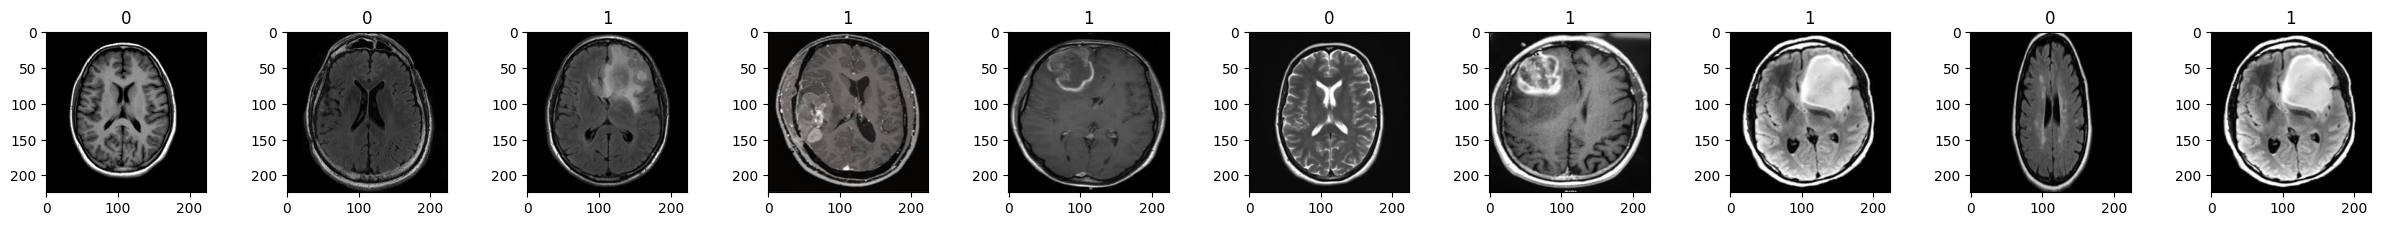

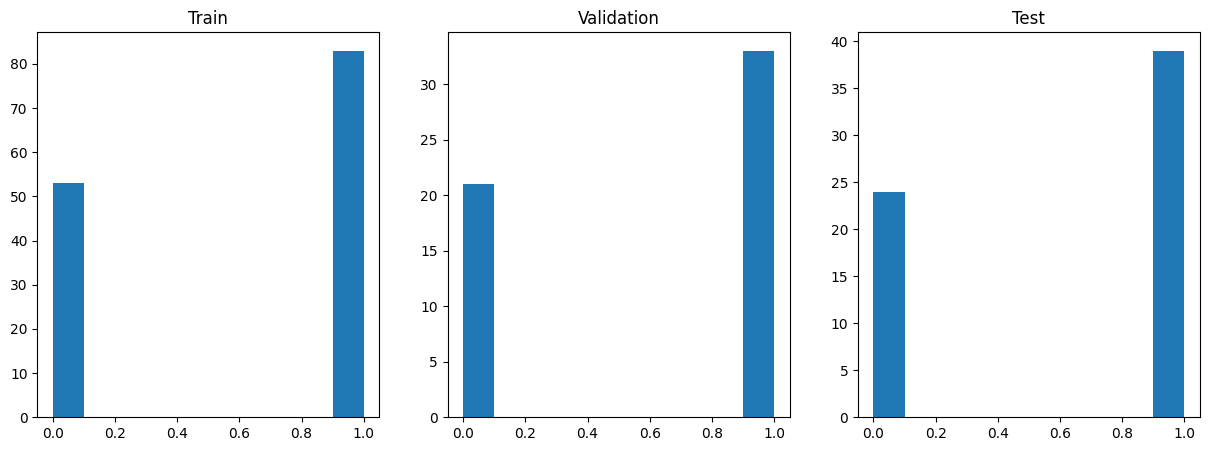

In [105]:
#Plot distribution of y among train, validation and test sets

def plot_distribution_of_y(y_train, y_val, y_test):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].hist(y_train)
    ax[0].set_title('Train')
    ax[1].hist(y_val)
    ax[1].set_title('Validation')
    ax[2].hist(y_test)
    ax[2].set_title('Test')
    plt.show()

def plot_samples(n):
    fig, ax = plt.subplots(1, n, figsize=(30, 30))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i in range(n):
        idx = np.random.randint(0, len(X_train))
        ax[i].imshow(X_train[idx])
        ax[i].set_title(y_train[idx])
    plt.show()

plot_samples(10)
plot_distribution_of_y(y_train, y_val, y_test)

In [106]:
X_train

array([[[[ 29,  31,  31],
         [ 29,  31,  31],
         [ 29,  31,  31],
         ...,
         [ 29,  31,  31],
         [ 29,  31,  31],
         [ 29,  31,  31]],

        [[ 29,  31,  31],
         [ 29,  31,  31],
         [ 29,  31,  31],
         ...,
         [ 29,  31,  31],
         [ 29,  31,  31],
         [ 29,  31,  31]],

        [[ 29,  31,  31],
         [ 29,  31,  31],
         [ 29,  31,  31],
         ...,
         [ 29,  31,  31],
         [ 29,  31,  31],
         [ 29,  31,  31]],

        ...,

        [[ 29,  31,  31],
         [ 29,  31,  31],
         [ 29,  31,  31],
         ...,
         [ 28,  30,  30],
         [ 28,  30,  30],
         [ 28,  30,  30]],

        [[ 29,  31,  31],
         [ 29,  31,  31],
         [ 29,  31,  31],
         ...,
         [ 29,  31,  31],
         [ 28,  30,  30],
         [ 28,  30,  30]],

        [[ 29,  31,  31],
         [ 29,  31,  31],
         [ 29,  31,  31],
         ...,
         [ 29,  31,  31],
        

In [107]:
def crop_along_image_contours(path, image_size, show_image = False):

    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # draw the outline of the object, then draw each of the
    # extreme points, where the left-most is red, right-most
    # is green, top-most is blue, and bottom-most is teal
    cv2.drawContours(image, [c], -1, (0, 255, 255), 2)
    cv2.circle(image, extLeft, 8, (0, 0, 255), -1)
    cv2.circle(image, extRight, 8, (0, 255, 0), -1)
    cv2.circle(image, extTop, 8, (255, 0, 0), -1)
    cv2.circle(image, extBot, 8, (255, 255, 0), -1)
    
    if show_image:
        cv2.imshow("Image", image)

    #crop the image along the extreme points
    cropped = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    #resize the image
    resized = cv2.resize(cropped, image_size)

    if show_image:
        cv2.imshow("Resized", resized)

    return resized

In [113]:
crop_along_image_contours(f"{train_dir}/yes/Y1.jpg", (224, 224), show_image=True)

array([[[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [9, 9, 9],
        [8, 8, 8],
        [8, 8, 8]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [8, 8, 8],
        [8, 8, 8],
        [8, 8, 8]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [8, 8, 8],
        [8, 8, 8],
        [8, 8, 8]],

       ...,

       [[5, 5, 5],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [5, 5, 5],
        [5, 5, 5],
        [5, 5, 5]]], dtype=uint8)